Thank you for showing interest in my profile and providing the opportunity to explore this interesting article. Despite prior commitments, I prioritized reading it and addressing the challenges on time. I hope you find the code enjoyable to review. 


# Challenge 1: Coding the OW and AFS Models

To code the **OW (Optimal Weight)** and **AFS (Alternative Functional Structure)** models, I use the formulas provided in **Section 2 (sub-section 2.3)**. The required parameters (\(\lambda\), \(\beta\), and \(p\)) are estimated using data from the `merged_data.csv` file. Below is the step-by-step procedure:--Impact

1. **Calculate the price variation (\(\Delta P\)):**
   d- Compute the difference between the best ask price (`best_ask`) and the best bid price (`best_bid`):
     \[
     \Delta P = \text{best\_ask} - \text{best\_bid}
     \]

2. **Estimate \(\lambda\) (Impact level):d**
   - Define \(\lambda\) as the ratio between \(\Delta P\) and the absolute signed volume (`Signed_Volume`):
     \[
     \lambda = \frac{\Delta P}{|\text{Signed VolumeFiltered    \]
   - Filter out values close to zero to avoid instability in the estimates.

3. **Estimate \(\beta\) (Decay edrate):**
   - Perform a linear regression between the logarithm of \(\Delta P\) and the relative time:
     \[
     \ln(\Delta P) = \text{Intercept} + \beta \cdot \text{Relative Time}
     \]
   - The slope of the regression line gives the value of \(\beta\).

4. **Estimate \(p\) (Non-linear impact padrameter for AFS):**
   - Use a log-log regression between the logarithm of \(\Delta P\) and the logarithm of the signed volume:
     \[
     \ln(\Delta P) = \text{Intercept} + p \cdot \ln(|\text{Signed Volume}|)
     \]
   - The slope of the regression line gives the value of \(p\).

5. **Calculdate and Compare Impacthe noDefine both OW and AFS models ation ofmpacts bas distribution of price impact for both modelss in predicting market behavior.


In [41]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt

Estimated Lambda: 0.000831
Estimated Beta: 0.000037
Estimation de p: -0.222896


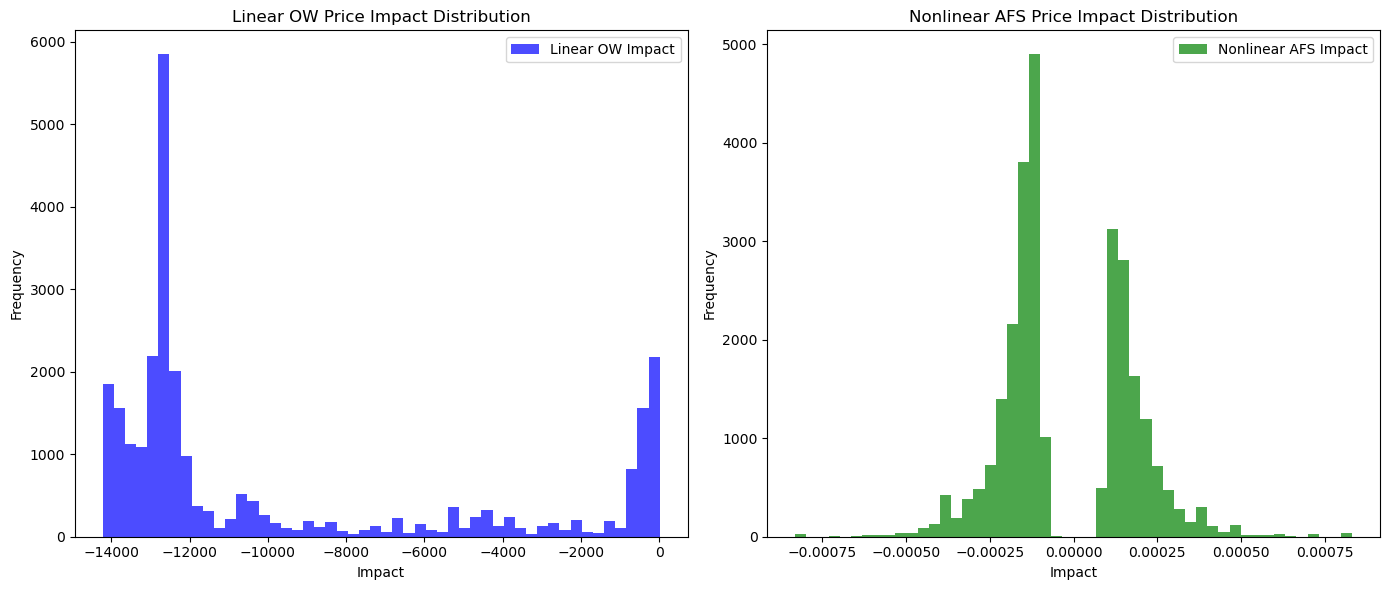

In [43]:
data = pd.read_csv('merged_data.csv')

# 1
data['Delta P'] = data['best_ask'] - data['best_bid']

# 2
data = data[(data['Delta P'].abs() > 1e-6) & (data['Signed Volume'].abs() > 1e-6)]  
# data = data[data['Signed Volume'].abs() > 1e-6]  # Filter out near-zero volumes
data['Lambda'] = data['Delta P'] / data['Signed Volume'].abs()
lambda_estimate = data['Lambda'].mean()
print(f"Estimated Lambda: {lambda_estimate:.6f}")

# 3
data['ts_event'] = pd.to_datetime(data['ts_event'])
data['Relative Time'] = (data['ts_event'] - data['ts_event'].iloc[0]).dt.total_seconds()
data['Log Delta P'] = np.log(data['Delta P'].clip(lower=1e-6))

# Fit regression to estimate beta
slope, intercept, _, _, _ = linregress(data['Relative Time'], data['Log Delta P'])
beta_estimate = -slope
print(f"Estimated Beta: {beta_estimate:.6f}")

# 4
data['Log Delta P'] = np.log(data['Delta P'].abs())
data['Log Signed Volume'] = np.log(data['Signed Volume'].abs())
slopeP, interceptP, r_value, p_value, std_err = linregress(data['Log Signed Volume'], data['Log Delta P'])
p_estimate = slopeP
print(f"Estimation de p: {p_estimate:.6f}")
p_afs = p_estimate 

# 5
# Linear OW Price Impact
data['OW Impact'] = 0.0
data['J_t'] = 0.0
for t in range(len(data)):
    J_t = 0.0
    for s in range(0, t+1):
        Q_s = data['Signed Volume'].iloc[s]
        J_t += Q_s * np.exp(-beta_estimate * (t - s))
    data.loc[t, 'J_t'] = J_t
    data.loc[t, 'OW Impact'] = lambda_estimate * J_t

# Nonlinear AFS Price Impact
data['AFS Impact'] = lambda_estimate * np.sign(data['Signed Volume']) * np.abs(data['Signed Volume']) ** p_afs

# distributions visualization
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(data['OW Impact'], bins=50, color='blue', alpha=0.7, label="Linear OW Impact")
plt.title("Linear OW Price Impact Distribution")
plt.xlabel("Impact")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(data['AFS Impact'], bins=50, color='green', alpha=0.7, label="Nonlinear AFS Impact")
plt.title("Nonlinear AFS Price Impact Distribution")
plt.xlabel("Impact")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

# Challenge 2: coding optimal strategy with linear impact 
as the strategy is defined in Theorem 4.2: 

--

1. **Calibrated Parameters:**
The following parameters are the same used in Section 6:
- **\(\phi = 0.139\)**: Mean reversion rate of the predictive signal, corresponding to a half-life of 5 days.
- **\(\sigma = 0.02\)**: Daily volatility of the asset prices, representing typical stock market volatility.
- **\(\alpha = 1.67 \times 10^{-4}\)**: Predictability of the signal, calibrated to reflect a strong theoretical Sharpe Ratio.
- **\(\lambda\)** and **\(\beta\)**: Explored as variables to understand their impact on performance:
  - \(\lambda\): Level of linear price impact.
  - \(\beta\): Decay rate of price impact.
- **\(\gamma = \text{Daily Risk}^2 / (N \cdot \sigma^2)\)**: Risk aversion parameter, ensuring the portfolio respects the specified daily risk (here 1.3M).
These parameters are applied uniformly across all assets, reflecting assumptions of homogeneity.
- The portfolio consists of **500 independent and homogeneous assets**:
  - Each asset has identical dynamics for price (\(S_t\)) and signal (\(f_t\)).
  - Independence simplifies calculations, allowing the global problem to be decomposed into 500 identical sub-problems.

- **Portfolio aggregation**:
  - The strategy is implemented individually for each asset.
  - Profits (PnL) and costs (transaction impact) are summed across all assets to calculate the portfolio's total performance.

--

2. **Optimal Strategy Implementation with Profit, Impact Costs and Sharpe Ratio:**
The strategy calculates the optimal positions \(Q_t\) using Theorem 4.2:
\[
Q_t = C_f f_t - C_J J_t
\]
Where:
- **\(C_f\)**: Coefficient based on predictability (\(f_t\)).
- **\(C_J\)**: Coefficient capturing the impact of transaction costs.
These coefficients depend on \(\lambda\), \(\beta\), and calibrated parameters (\(\alpha, \phi, \sigma, \gamma\)).
- **Profit and Loss (PnL)**:
  - Calculated as \(PnL[t] = Q_t[t-1] \cdot dS_t\), where \(dS_t\) represents simulated price changes.
- **Impact costs**:
  - Linear cost model: \(impact\_costs[t] = \lambda \cdot |dQ_t|\), proportional to the size of the transaction.

The net profit is computed as:
\[
\text{Net PnL} = \sum (\text{PnL}) - \sum (\text{Impact Costs})
\]

- **Sharpe Ratio :** is calculated as:
\[
\text{Sharpe Ratio} = \frac{\mathbb{E}[\text{PnL}]}{\sqrt{\text{Var}[\text{PnL}]}}
\]
Where:
  - **\(\mathbb{E}[\text{PnL}]\)**: Mean profit.
  - **\(\text{Var}[\text{PnL}]\)**: Variance of profit (risk).

--

3. **Parameter Exploration:**
The code explores the impact of \(\beta\) and \(\lambda\) on the Sharpe Ratio:
- **Variation of \(\beta\)**:
  - Fix \(\lambda\) and calculate the Sharpe Ratio for a range of \(\beta\).
- **Variation of \(\lambda\)**:
  - Fix \(\beta\) and calculate the Sharpe Ratio for a range of \(\lambda\).

The results are visualized as two plots showing the Sharpe Ratio's sensitivity to these parameters, when the DR = 1.3M.


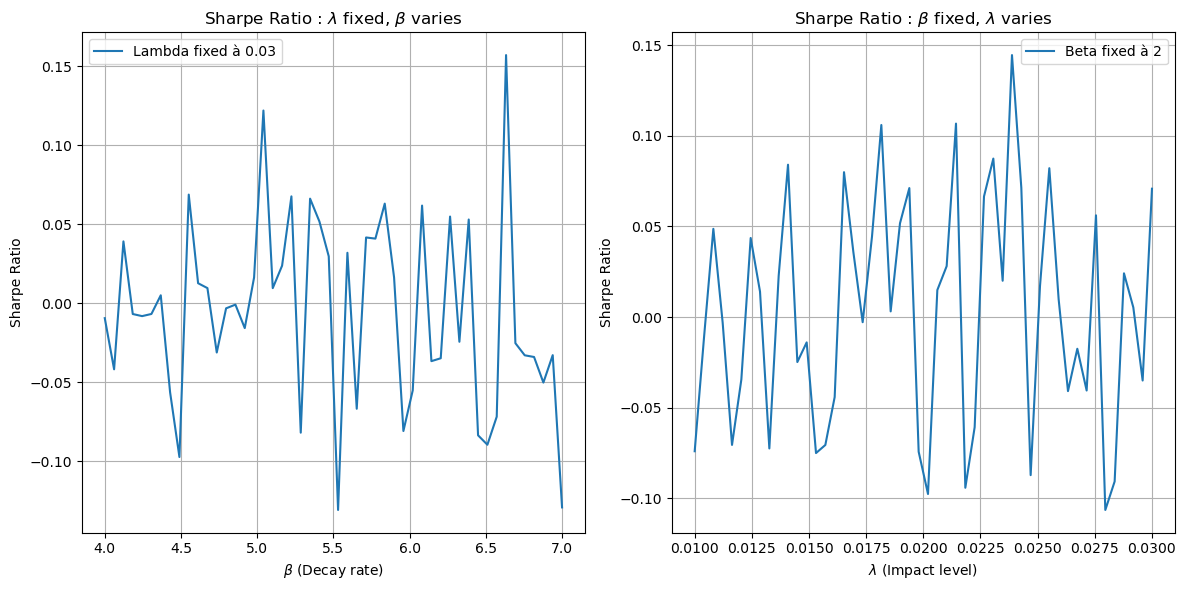

In [47]:
# 1
num_days = 252  
dt = 1 / num_days  
N = 500  
sigma = 0.02  
phi = 0.139  
alpha = 1.67e-4  
daily_risk = 1.3e6  
gamma = daily_risk**2 / (N * sigma**2)  
lambda_fixed = 0.03  
beta_fixed = 2
beta_values = np.linspace(4, 7, 50)  
lambda_values = np.linspace(0.01, 0.03, 50)  

# 2
#Simulation of predictif signal
def simulate_signal(num_days, phi):
    f_t = np.zeros(num_days)
    for t in range(1, num_days):
        dW = np.random.normal(0, np.sqrt(dt))  
        f_t[t] = f_t[t - 1] - phi * f_t[t - 1] * dt + np.sqrt(2 * phi) * dW
    return f_t

def optimal_strategy(beta, lambda_):
    f_t = simulate_signal(num_days, phi)
    Cf = alpha * (1 + beta / phi) / (gamma * sigma**2 * np.sqrt(1 + 2 * lambda_ * beta / (gamma * sigma**2) + beta / phi))
    CJ = np.sqrt(1 + 2 * lambda_ * beta / (gamma * sigma**2)) - 1
    Q_t = np.zeros(num_days)  
    PnL = np.zeros(num_days)  
    impact_costs = np.zeros(num_days)  
    for t in range(1, num_days):
        J_t = Q_t[t - 1] - beta * Q_t[t - 1] * dt  
        Q_t[t] = Cf * f_t[t - 1] - CJ * J_t  # the Optimal Strategy
        # Compute profits and impact costs
        dQ = Q_t[t] - Q_t[t - 1]
        dS = alpha * f_t[t - 1] * dt + sigma * np.random.normal(0, np.sqrt(dt))  
        PnL[t] = Q_t[t - 1] * dS  
        impact_costs[t] = lambda_ * abs(dQ)  
    # PnL net
    total_PnL = np.sum(PnL) - np.sum(impact_costs)
    sharpe_ratio = np.mean(PnL) / np.std(PnL)  # Sharpe ratio
    return sharpe_ratio

# 3
sharpe_beta_varies = [optimal_strategy(beta, lambda_fixed) for beta in beta_values]
sharpe_lambda_varies = [optimal_strategy(beta_fixed, lambda_) for lambda_ in lambda_values]

# Visualization
plt.figure(figsize=(12, 6))

# Curve 1: Beta varies, Lambda fixed
plt.subplot(1, 2, 1)
plt.plot(beta_values, sharpe_beta_varies, label=f"Lambda fixed à {lambda_fixed}")
plt.xlabel(r"$\beta$ (Decay rate)")
plt.ylabel("Sharpe Ratio")
plt.title(r"Sharpe Ratio : $\lambda$ fixed, $\beta$ varies")
plt.grid(True)
plt.legend()

# Curve 2: lambda varies, beta fixed
plt.subplot(1, 2, 2)
plt.plot(lambda_values, sharpe_lambda_varies, label=f"Beta fixed à {beta_fixed}")
plt.xlabel(r"$\lambda$ (Impact level)")
plt.ylabel("Sharpe Ratio")
plt.title(r"Sharpe Ratio : $\beta$ fixed, $\lambda$ varies")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Challenge 3: Implementing and Training the Deep Learning Model
for discrete setting in **Appendix C.2** of the paper


#### 1. Parameterl:
- **(\alpha = 0.1):** Controls how much we care about returns.
- **(\gamma = 0.01):** Penalizes taking large positions (risk aversion).
- **(\lambda = 0.1):** Represents trading costs due to market impact.
- **(\beta = 0.2):** Controls how long the trading impact lasts.
- **(T = 100):** Total trading time.
- **(dt = 1):** The time step size.
- **(n_steps = T // dt):** Total number of steps for the trading horizon.

#### 2. Simulating Tradg Signals
I simulated trading signals (\(f_t\)) using a normal dist mean = 0 and 
- Mean = 0
- Standard deses this simulation.

#### 3. Defining theeep Learning Model
I built a neural network to figure out the best trading strategy. Here’s the structure:
- **Input:** A sequence of signals over time (\(n_steps\)).
- **Hidden Layers:** Dense layers with ReLU activation.
- **Output:** A single trading position (\(Q_t\)) for each time step.

The `ate_model` function lets me try different numbers of layers and hidden unit

#### 4. Loss Function
I included three parts in the loss function:
- **Returns:** \(-\alpha \cdot Q_t \cdot f_t\) (negative because we want to maximiz because p \in (0,1), |Q_t|^(p+1), is simplified to Q_t^2. soe returns).
- **Impact Co \(\lambda here the t Q_t^2\), which represents the cost of trading.
- **Risk Costs:** \(\gamma \cdot Q_t^2\), to limit risk by avoiding large positions.

The total loss is the sum of these, and it gets minimized during traUng.

#### 5. Training the Model
I used the `train_model` function to train the model with the Adam optimizer:
- The data is split into batches for training.
- Training runs for 50 epochs with a batch size of 32.
- I tracked the loss at each epoch to see how the model improved.

#### 6. Comparing Network Structures
I tried different setups for the model:
- **16 hidden units, 1 layer.**
- **32 hidden units, 2 layers.**
- **64 hidden units, 3 layers.**

I compared their training losses to see which one worked best.

#### 7. Visualizing the Results
I plotted the training losses for all the models. This helped me figure out which network structure performed better and gave better insights into the strategies.
providing insights into the performance of different network architectures.


In [73]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


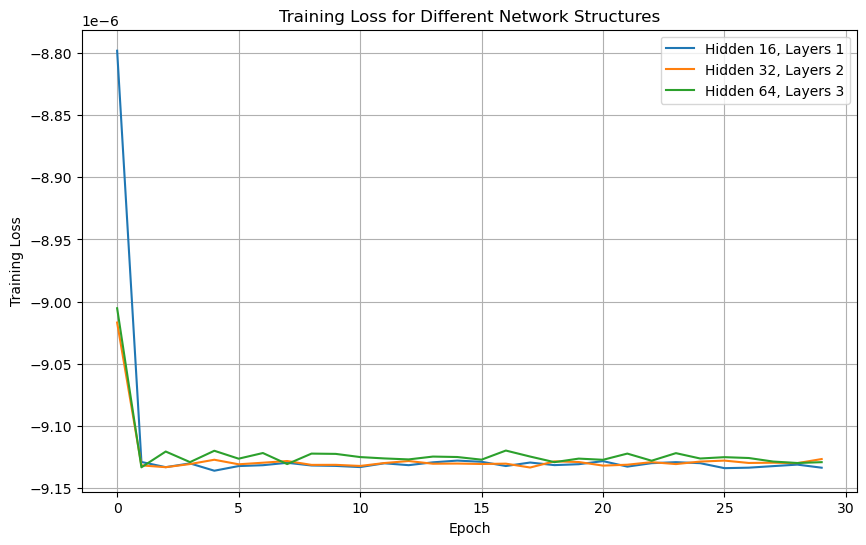

In [49]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
# 1 Parameters based on Appendix C.2
alpha = 0.1  
gamma = 0.01  
lambda_param = 0.1  
beta = 0.2  
T = 100  
dt = 1  
n_steps = T // dt  

# 2 
def simulate_signals(n_samples, n_steps, alpha, sigma=0.02):
    ft = np.random.normal(0, sigma, (n_samples, n_steps))  
    return ft
# Generate data
n_samples = 5000
ft = simulate_signals(n_samples, n_steps, alpha) # predictive signal

# 3
def create_model(hidden_units=32, n_layers=2):
    model = models.Sequential()
    model.add(layers.Input(shape=(n_steps, 1)))  
    for _ in range(n_layers):
        model.add(layers.Dense(hidden_units, activation="relu"))
    model.add(layers.Dense(1))  
    return model

# 4
def compute_loss(Q_pred, ft, lambda_param, gamma, beta):    
    impact_cost = lambda_param * tf.reduce_mean(Q_pred ** 2, axis=1)
    risk_cost = gamma * tf.reduce_mean(Q_pred ** 2, axis=1)
    returns = -alpha * tf.reduce_mean(Q_pred * ft, axis=1)
    # all costs
    total_loss = tf.reduce_mean(returns + impact_cost + risk_cost)
    return total_loss

# 6
def train_model(model, ft, epochs=50, batch_size=32):
    optimizer = optimizers.Adam()
    loss_history = []
    for epoch in range(epochs):
        indices = np.random.permutation(len(ft))
        ft_shuffled = ft[indices]
        epoch_loss = 0
        for i in range(0, len(ft), batch_size):
            ft_batch = ft_shuffled[i:i + batch_size]
            with tf.GradientTape() as tape:
                Q_pred = model(ft_batch[..., None], training=True)
                loss = compute_loss(Q_pred, ft_batch[..., None], lambda_param, gamma, beta)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            epoch_loss += loss.numpy()
        loss_history.append(epoch_loss / (len(ft) // batch_size))
    return loss_history

# 6
structures = [(16, 1), (32, 2), (64, 3)]  # (hidden_units, n_layers)
loss_histories = {}

for hidden_units, n_layers in structures:
    model = create_model(hidden_units, n_layers)
    loss_history = train_model(model, ft, epochs=30)
    loss_histories[f"Hidden {hidden_units}, Layers {n_layers}"] = loss_history

# 7
plt.figure(figsize=(10, 6))
for label, loss_history in loss_histories.items():
    plt.plot(loss_history, label=label)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss for Different Network Structures")
plt.legend()
plt.grid()
plt.show()